In [12]:
import os
import pandas as pd
import numpy as np
%matplotlib inline

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [13]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [14]:
housing = load_housing_data()

## Take a look at data

In [15]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [16]:
housing.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [17]:
# All values except for ocean_proximity is object
housing["ocean_proximity"].value_counts() # look at values

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [18]:
# Descriptive Statistics
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


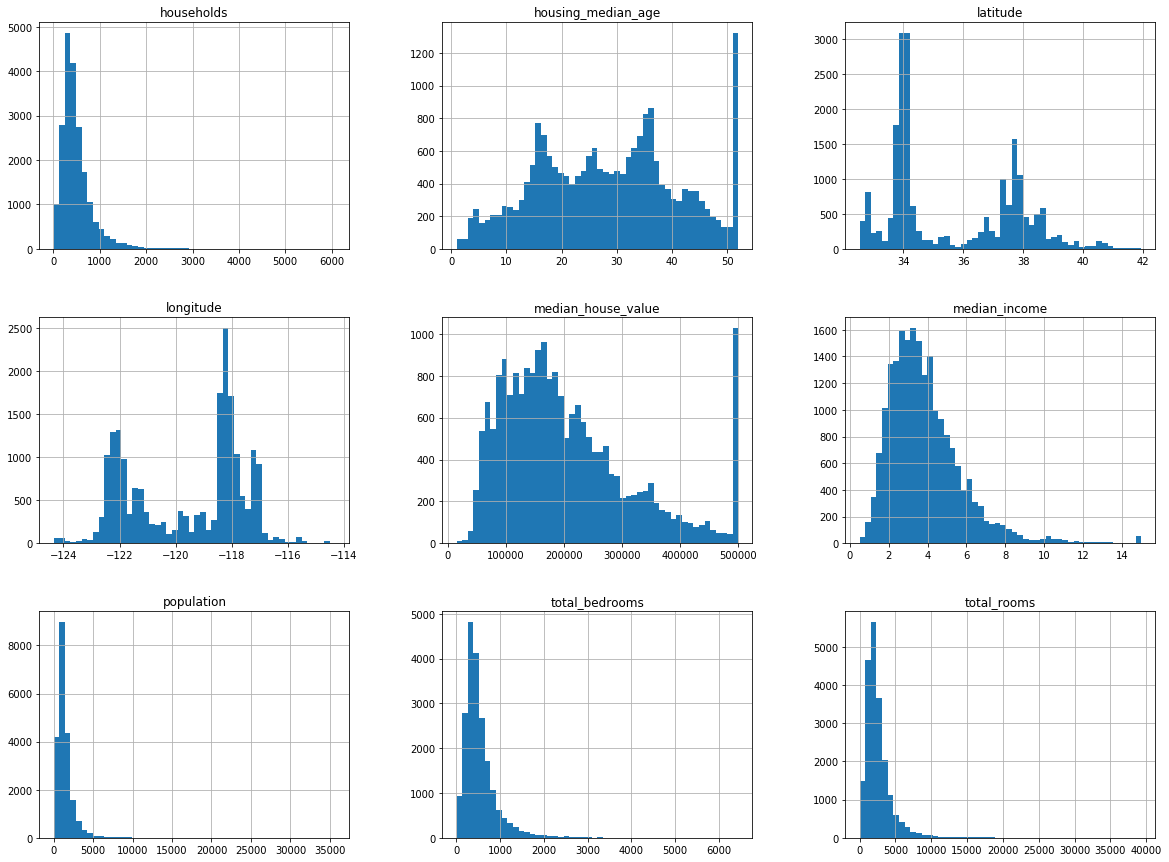

In [19]:
# Plot histogram
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

# 1. Median income is not to scale, and capped. Median age is capped
# 2. Median house value is capped -- target value (maybe remove the outliers)
# 3. Tail heavy -- more to right than left

## Split Train-Test set

Before looking at data any further

In [20]:
from sklearn.model_selection import train_test_split

# Simple
simple_train_set, simple_test_set = train_test_split(housing, test_size=0.2, random_state=42)

( simple_test_set.shape, simple_train_set.shape )

((4128, 10), (16512, 10))

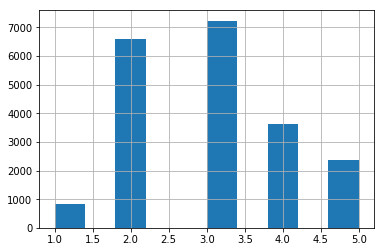

In [21]:
# Stratified Sampling 
# * make sure sample is representative in terms of ratio
# * not important if the data is large enough

# In this case, median income, group it into categories so we can use to statified sample
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=  [0.,1.5,3.0,4.5,6., np.inf],
                               labels=[1, 2,  3,  4,  5])
housing["income_cat"].hist()

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [23]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize

In [24]:
h = strat_train_set.copy()

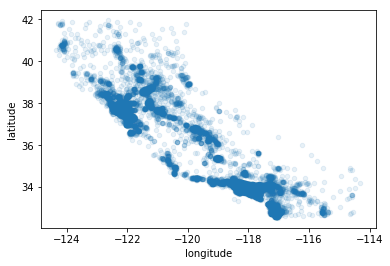

In [25]:
h.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1) # Alpha to better see density

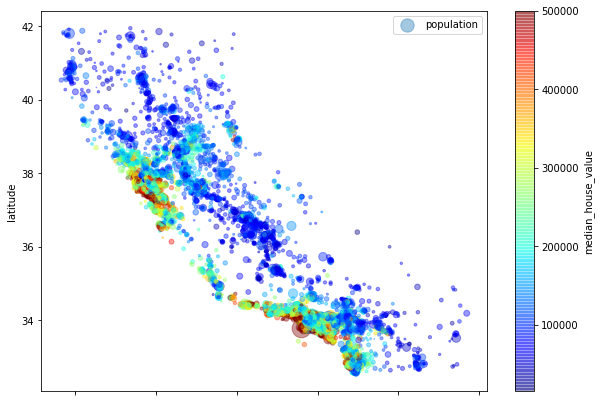

In [26]:
h.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
      s=housing["population"]/100, label="population",
      c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
      figsize=(10,7))
plt.legend()

### Find Correlations


In [27]:
corr_matrix = h.corr()

In [28]:
## Find if any of the value correlates
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11867fd30>,
      dtype=object)

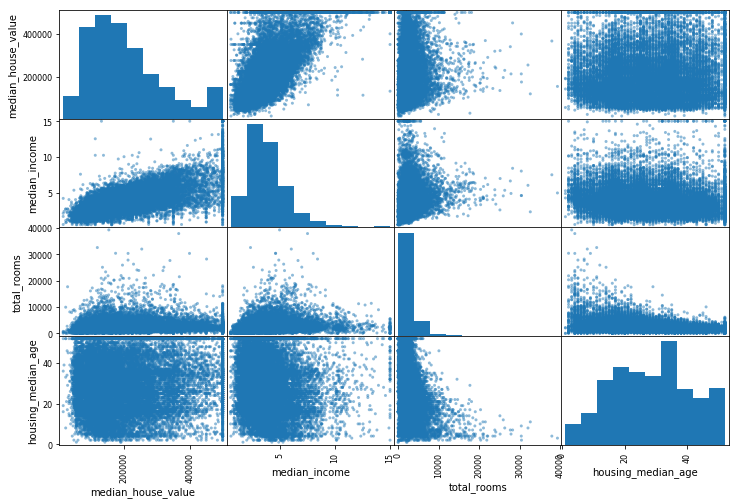

In [29]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8)) ## House value vs Median income is most promising

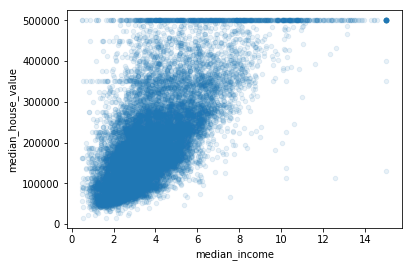

In [30]:
h.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

## New Attributes

In [31]:
h["rooms_per_household"] = h["total_rooms"]/h["households"]
h["bedrooms_per_room"] = h["total_bedrooms"]/h["total_rooms"]
h["population_per_household"]=h["population"]/h["households"]

In [32]:
h.corr()["median_house_value"].sort_values(ascending=False)
# Room per household coorelates more than total rooms

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Prepare for ML
### Separate Feature/Label

In [33]:
# Need to separate between predictor and label
h = strat_train_set.drop("median_house_value", axis=1)
h_labels = strat_train_set["median_house_value"].copy()

### Put in missing value

In [34]:
# Missing Value
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
housing_num = h.drop("ocean_proximity", axis=1)
imputer.fit(h.drop("ocean_proximity", axis=1))

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [35]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [36]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [37]:
X = imputer.transform(housing_num) ## This is a numpy array

In [38]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns) ## Turn it back to pandas

### Categorical Data
There are 2 ways

1. Ordinal -- this will assume that two nearby values are related
2. OneHot
3. Embedding 
4. Find related value (e.g. country --> population, GDP per capita

In [39]:
housing_cat = h[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [40]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [41]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Scikit-Learn pipelines

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()) #### SCALER to the train data set only
])

pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])
housing_prepared = pipeline.fit_transform(h)

In [44]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

## Train Model

Linear Regression

In [45]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, h_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [46]:
## Test it out
some_data = h.iloc[:5] ## first 5
some_labels = h_labels.iloc[:5]

some_data_prepared = pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [50]:
## RMSE on training set
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(h_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
( lin_rmse, np.median(h_labels) ) 

(68628.19819848923, 179500.0)

### Decision Tree

In [51]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, h_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [53]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(h_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [55]:
# K-Fold cross validation

from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, h_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

print(tree_rmse_scores)
print(tree_rmse_scores.mean())
print(tree_rmse_scores.std()) # Tell how precise the estimates are

[68873.3087744  66831.14557095 71083.75706695 69101.73207707
 70951.67285016 75837.00157519 70763.22236451 71030.40008054
 78287.99367107 69833.13011531]
71259.33641461558
3205.8133142225556


In [58]:
lin_scores = cross_val_score(lin_reg, housing_prepared, h_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print(lin_rmse_scores)
print(lin_rmse_scores.mean())
print(lin_rmse_scores.std())

[66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
69052.46136345083
2731.674001798346


In [60]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, h_labels)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [61]:
forest_scores = cross_val_score(forest_reg, housing_prepared, h_labels,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print(forest_rmse_scores)
print(forest_rmse_scores.mean())
print(forest_rmse_scores.std())

[53020.0812354  49939.98953838 51210.62334138 54103.03975722
 51809.67665879 54971.02386685 51396.59242824 51350.29502043
 55850.2093817  53040.25965054]
52669.17908789286
1772.223730653572


## Grid Search

In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, h_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [63]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [64]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [66]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63906.35526022428 {'max_features': 2, 'n_estimators': 3}
55372.154210873465 {'max_features': 2, 'n_estimators': 10}
52868.17294094011 {'max_features': 2, 'n_estimators': 30}
60194.96944816411 {'max_features': 4, 'n_estimators': 3}
53074.36161190943 {'max_features': 4, 'n_estimators': 10}
50638.735405017556 {'max_features': 4, 'n_estimators': 30}
59110.366346679155 {'max_features': 6, 'n_estimators': 3}
52259.18856343886 {'max_features': 6, 'n_estimators': 10}
50249.70266762982 {'max_features': 6, 'n_estimators': 30}
58518.39064701139 {'max_features': 8, 'n_estimators': 3}
52170.72929042271 {'max_features': 8, 'n_estimators': 10}
49996.700060124844 {'max_features': 8, 'n_estimators': 30}
62289.58408848279 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53488.68015464613 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59911.77133191584 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52820.0326694132 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [78]:
# Feature importance -- for random forest regressor
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.40031316549132306, 'median_income'),
 (0.14623912220389768, 'INLAND'),
 (0.10714660732273504, 'pop_per_hhold'),
 (0.07230926229466389, 'longitude'),
 (0.06934420838360031, 'latitude'),
 (0.04415413882048433, 'bedrooms_per_room'),
 (0.04235180906574734, 'housing_median_age'),
 (0.04184043943195547, 'rooms_per_hhold'),
 (0.01524755966338497, 'total_bedrooms'),
 (0.015144990549653063, 'total_rooms'),
 (0.014328523598105195, 'population'),
 (0.013992867926244776, 'households'),
 (0.01169231265173195, '<1H OCEAN'),
 (0.003169012470917661, 'NEAR BAY'),
 (0.0026520333897346103, 'NEAR OCEAN'),
 (7.394673582058891e-05, 'ISLAND')]

## Test Set

In [79]:
final_model = grid_search.best_estimator_

In [83]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = pipeline.transform(X_test)

In [84]:
final_predictions = final_model.predict(X_test_prepared)

In [85]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) 
final_rmse

47513.614068108465